# Evaluation script for asvspoof-ood

To run this jupyter notebook:

1. Please use the conda environment in [../../tutorials/env-cpu.yml](../../tutorials/env-cpu.yml). It will install matplotlib, pandas, and other utils;

2. Make sure this project-NN-Pytorch-scripts is in your PYTHONPATH

3. Please run 00_demo.sh to get the score files beforing running this notebook

Note: 

1. tools to compute cllr are not included. Please check https://gitlab.eurecom.fr/nautsch/pybosaris


In [5]:
import os
import sys
import numpy as np

import pandas as pd
import sklearn.metrics as sklearn_metrics

from sandbox import eval_asvspoof
from core_scripts.data_io import io_tools
from tutorials.plot_tools import plot_API
from tutorials.plot_tools import plot_lib
from tutorials.plot_tools import table_API

import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [68]:
# Macros
g_label_tag = 'label'
g_label_bona = 'bonafide'
g_attack_tag = 'attack'
g_score_tag = 'score'

g_bona_tag = '-'
g_dev_groups = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']
g_eval_groups = ['A16', 'A19', 'A07', 'A08', 'A09', 'A17', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A18']

g_inout_col = 'inoutlabel'

# 1: in-distribution (known)
# 0: out-distribution (unknown)
g_in_out_map = {'-': 1, 
                'A01': 1, 'A02': 1, 'A03': 1, 'A04': 1, 'A05': 1, 'A06': 1, 
                'A16': 1, 'A19': 1, 
                'A07': 0, 'A08': 1, 'A09': 1, 'A17': 0, 
                'A10': 0, 'A11': 0, 'A12': 0, 'A13': 0, 'A14': 0, 'A15': 0, 'A18': 0}

In [172]:
# Utils

# whether trial is in (known) or out (unknown)
def get_ood_label(label):
    return 'in' if label in g_in_out_map and g_in_out_map[label]==1 else 'out'

def get_ood_label_manual(label, inlabel):
    return 'out' if label == g_label_bona else inlabel

# Parse protocols
def parse_protocol(protocol_path):
    tmp_pd = pd.read_csv(protocol_path, names = ['voice', 'trial', '-', 'attack', 'label'], sep = ' ', index_col = 'trial')
    tmp_pd.insert(0, g_inout_col, tmp_pd['attack'].apply(lambda x: get_ood_label(x)))
    
    # get_ood_label cannot decide whether bonafide of VCC is in or out
    # do it manually
    if not tmp_pd.index[0].startswith('LA'):
        # this is not ASVspoof protocol, then all bonafide should be out
        tmp_pd[g_inout_col] = tmp_pd.apply(lambda x: get_ood_label_manual(x['label'], x[g_inout_col]), axis=1)
    return tmp_pd

# Parse score.txt
def parse_score(score_file):
    return pd.read_csv(score_file, names = ['trial', 'tmp', 'score', 'conf'],  sep = ' ', skipinitialspace=True, index_col = 'trial')

# Load score file and merge with protocol
def load_pd(filepaths, protocol_pd, applyfunc_score=None, applyfunc_conf=None):
    """ 
    Args
    ----
      filepaths: list of string, path to score.txt files
      protocol_pd: pandas frame, protocol
      apply_func_score: function to transform CM score
      apply_func_conf: function to transform confidence score
      
    Return
    ------
      merged_pd: pandas frame, containing both scores and protocol entries
    """
    #inoutlabel      score       conf    voice attack     label  -  \
    #trial                                                                        
    #LA_E_1000147        out -11.330429  37.360504  LA_0044    A10     spoof  -   
    #LA_E_1000273        out -13.465729  35.140652  LA_0001    A15     spoof  -
    
    for filename in filepaths:
        if not os.path.isfile(filename):
            print("Cannot find {:s}".format(filename))
            print("Please make sure this file has been generated. Otherwise, run 00_demo.sh")
            sys.exit(1)
    
    # file that contains score and conf
    score_pd = pd.concat([parse_score(x) for x in filepaths])
    
    if applyfunc_conf:
        score_pd['conf'] = score_pd['conf'].apply(applyfunc_conf)
    if applyfunc_score:
        score_pd['score'] = score_pd['score'].apply(applyfunc_score)
        
    merged_pd = score_pd.join(protocol_pd) 
    merged_pd = merged_pd[~merged_pd['score'].isna()]
    
    return merged_pd

In [173]:
# Utils

# compute EERs
def compute_eer(tmp_pd):
    bona_score = tmp_pd.query("label == 'bonafide'")['score'].to_numpy()
    spoof_score = tmp_pd.query("label == 'spoof'")['score'].to_numpy()
    eer, threshold = eval_asvspoof.compute_eer(bona_score, spoof_score)
    
    # cllr is not included in this script
    #cllr_value = cm.cllr(bona_score, spoof_score)
    #min_cllr_value = cm.min_cllr(bona_score, spoof_score)
    return eer, 0


# compute metrics
def compute_metrics(pd, conf_col = 'conf', inout_col = g_inout_col, tpr_threshold = 0.95):
    """
    Args
    ----
      pd: pandas frame, return from load_pd
      conf_col: string, name of the column for confidence score
      inout_col: string, name of the column to indicate in/out
      tpr_threshold: threshold for abstention
      
    Return
    ------
      fpr95
      auroc
      apc
      eer95
    """
    ood_labels = pd[inout_col].to_numpy()
    conf_scores = pd[conf_col].to_numpy()
    
    #tpr_threshold = 0.95
    fpr, tpr, threshold = sklearn_metrics.roc_curve(ood_labels, conf_scores, pos_label='in')
    idx = np.argmin(np.abs(tpr - tpr_threshold))
    fpr95 = fpr[idx]
    thre95 = threshold[idx]
    
    # EER under tpr=0.95
    if len(pd.loc[pd[conf_col] > thre95]):
        eer95, _ = compute_eer(pd.loc[pd[conf_col] > thre95])
    else:
        eer95 = np.inf
    
    # AUROC and AUPC
    ood_labels_tmp = [x == 'in' for x in ood_labels]
    auroc = sklearn_metrics.roc_auc_score(ood_labels_tmp, conf_scores)
    apc = sklearn_metrics.average_precision_score(ood_labels, conf_scores, pos_label='in')
    return fpr95, auroc, apc, eer95




In [174]:
# Utils to plot figure

import itertools
from matplotlib import ticker

def plot_conf_cm_score(tmppd, conf_col = 'conf', 
                       inout_col = g_inout_col, score_col = 'score', 
                       label_col = 'label', sample_ratio=0.1,
                       plot_for_debug=False):
    """ 
    Args
    ----
      pd: pandas frame, return from load_pd
      conf_col: string, name of the column for confidence score
      inout_col: string, name of the column to indicate in/out
      score_col: string, name of the column for CM score
      label_col: string, name of the column for CM label
      sampling_ratio: float, we don't plot all the scores on scatter point -- too many
                      we draw samples from the scores
                      
    Return
    ------
      fig: matplotlib fig handler
      axis: matplotlib axis handler
    """
    # 2d scatter
    color_list = ['b',  'r', 'grey', 'c' ]
    
    ood_label_bags = tmppd[inout_col].unique()
    ood_label_bags.sort()
    cm_label_bags = tmppd[label_col].unique()
    
    # 2D scatter
    data_bags, data_config_bag = [], []
    
    # ood dist
    ood_bags, ood_config_bag = [], []
    
    # cm dist
    cm_bags, cm_config_bag = [], []
    
    # 
    xlim = [np.percentile(tmppd[score_col].to_numpy(), 0.1) - np.abs(np.percentile(tmppd[score_col].to_numpy(), 0.1)) * 0.1,
            np.percentile(tmppd[score_col].to_numpy(), 99.9) + np.abs(np.percentile(tmppd[score_col].to_numpy(), 99.9)) * 0.1]
    ylim = [np.percentile(tmppd[conf_col].to_numpy(), 0.1) - np.abs(np.percentile(tmppd[conf_col].to_numpy(), 0.1)) * 0.1,
            np.percentile(tmppd[conf_col].to_numpy(), 99.9) + np.abs(np.percentile(tmppd[conf_col].to_numpy(), 99.9)) * 0.1]
    
    for idx, (cm_label, ood_label) in enumerate(itertools.product(cm_label_bags, ood_label_bags)):
        #print(ood_label, cm_label)
        
        query = "{:s} == '{:s}' and {:s} == '{:s}'".format(inout_col, ood_label, label_col, cm_label)
        tmp = tmppd.query(query)
        print(query, len(tmp))
        conf_score = tmp[conf_col].to_numpy()
        cm_score = tmp[score_col].to_numpy()
        
        
        if len(conf_score) and len(cm_score):
            #xlim = [np.percentile(cm_score, 0.1), np.percentile(cm_score, 99.9)]
            #ylim = [np.percentile(conf_score, 0.1), np.percentile(conf_score, 99.9)]
            if sample_ratio > 0:
                # randomly sample a few data for plotting
                data_index = np.arange(cm_score.shape[0])
                np.random.shuffle(data_index)
                data_index = data_index[0:int(data_index.shape[0] * sample_ratio)]
                data_bags.append(np.stack([cm_score[data_index], conf_score[data_index]], axis=1))
            else:
                data_bags.append(np.stack([cm_score, conf_score], axis=1))
            data_config_bag.append(
                {"plot_scatter": {"alpha": 0.05, "s": 5, "marker": 'o', "color": color_list[idx]},
                 'xlabel': "CM score", 'ylabel': "Confidence score", 'xlim':xlim, 'ylim': ylim, 
                 "grid": {'b': True, 'linestyle': ':', 
                          'linewidth': 0.5, 'color': 'k', 
                          'zorder':3}})
            
        if len(conf_score):
            ood_bags.append(conf_score)
            ood_config_bag.append({'plot_hist': {'histtype':'step', 'density':True, 'bins':100, 'color': color_list[idx], 'orientation': 'horizontal'}, 
                                   'yticks': [], 'yticklabels': [], 'xticks': [], 'ylim':ylim})

        if len(cm_score):
            cm_bags.append(cm_score)
            cm_config_bag.append({'plot_hist': {'histtype':'step', 'density':True, 'bins':100, 'color': color_list[idx]}, 
                                  'xticks': [], 'xticklabels': [], 'yticks': [], 'xlim':xlim})
    
    max_trial_num = max([len(x) for x in ood_bags])
    for idx in range(len(ood_bags)):
        if len(ood_bags[idx]) < max_trial_num * 0.1:
            data_config_bag[idx]['plot_scatter']['s'] = 10
            data_config_bag[idx]['plot_scatter']['alpha'] = 0.1
    
    fig, axis = plot_API.plot_API2(data_bags + ood_bags + cm_bags,
                       [plot_lib.plot_scatter for x in data_bags] + [plot_lib.plot_hist for x in ood_bags] + [plot_lib.plot_hist for x in cm_bags],
                       [[[1, 3], [0, 2]] for x in data_bags] + [[[1, 3], [2, 3]] for x in ood_bags] + [[[0, 1], [0, 2]] for x in cm_bags],
                       {'figsize': (9.44/4, 9.44/4), 'wspace': 0.1, 'hspace': 0.1,
                        'subconfig': data_config_bag + ood_config_bag + cm_config_bag}, verbose=False)
    axis[len(data_bags)].axis("off")
    axis[len(data_bags)+len(ood_bags)].axis("off")
    
    return fig, axis


def print_results(eer, eer95, fpr95, auroc, apc):
    print("Metrics without considering abstention: ")
    print("EER: {:.3f}%".format(eer * 100))
    
    print("\nMetrics for abstention: ")
    print("AUROC: {:.3f}%".format(auroc * 100))
    print("AUPR: {:.3f}%".format(apc * 100))
    
    print("\nMetrics with abstention considered: ")
    print("EER at TPR=95%: {:.3f}%".format(eer95 * 100))
    print("FPR at TPR=95%: {:.3f}%".format(fpr95 * 100))
    

# Run the scripts

In [189]:
# Load all the protocols 
prjdir = './'

bc_protocol_pd = parse_protocol(prjdir + '/DATA/bc_release/protocol.txt')
asv_protocol_pd = parse_protocol(prjdir + '/DATA/asvspoof2019_LA/protocol.txt')
vcc_protocol_pd = parse_protocol(prjdir + '/DATA/vcc_release/protocol.txt')
protocol_pd = pd.concat([bc_protocol_pd, asv_protocol_pd, vcc_protocol_pd])

## Using AM-softmax-maxprob

inoutlabel == 'in' and label == 'spoof' 19656
inoutlabel == 'out' and label == 'spoof' 44226
inoutlabel == 'in' and label == 'bonafide' 7355
inoutlabel == 'out' and label == 'bonafide' 0


/home/smg/wang/WORK/WORK/CODE/git_local/team/project-NN-Pytorch-scripts/tutorials/plot_tools/plot_API.py:325: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = fig.add_subplot(gs[grid_config[0][0]:grid_config[0][1],


Metrics without considering abstention: 
EER: 4.633%

Metrics for abstention: 
AUROC: 50.755%
AUPR: 38.276%

Metrics with abstention considered: 
EER at TPR=95%: inf%
FPR at TPR=95%: 98.198%


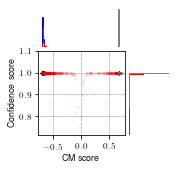

In [192]:
## On test set I 

# path to the score file
score_file = [prjdir + '/AM-softmax-maxprob/config_train_asvspoof2019/01/log_output_pretrained_config_test_asvspoof2019_score.txt']

# Note that for AM-softmax, the score from the script contains the scaling hyper-paraneter \alpha=20
# We can divide it by x/20
merged_pd = load_pd(score_file, protocol_pd, lambda x: x/20, None)

eer, _ = compute_eer(merged_pd)
fig, axis = plot_conf_cm_score(merged_pd)
fpr95, auroc, apc, eer95 = compute_metrics(merged_pd)
print_results(eer, eer95, fpr95, auroc, apc)

inoutlabel == 'in' and label == 'spoof' 19656
inoutlabel == 'out' and label == 'spoof' 93693
inoutlabel == 'in' and label == 'bonafide' 7355
inoutlabel == 'out' and label == 'bonafide' 770


/home/smg/wang/WORK/WORK/CODE/git_local/team/project-NN-Pytorch-scripts/tutorials/plot_tools/plot_API.py:325: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = fig.add_subplot(gs[grid_config[0][0]:grid_config[0][1],


Metrics without considering abstention: 
EER: 6.228%

Metrics for abstention: 
AUROC: 50.805%
AUPR: 22.518%

Metrics with abstention considered: 
EER at TPR=95%: inf%
FPR at TPR=95%: 98.098%


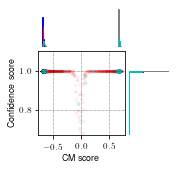

In [196]:
## On test set II 

# path to the score file
score_file = [prjdir + '/AM-softmax-maxprob/config_train_asvspoof2019/01/log_output_pretrained_config_test_asvspoof2019_score.txt',
              prjdir + '/AM-softmax-maxprob/config_train_asvspoof2019/01/log_output_pretrained_config_test_vcc_score.txt']

merged_pd = load_pd(score_file, protocol_pd, lambda x: x/20, None)

eer, _ = compute_eer(merged_pd)
fig, axis = plot_conf_cm_score(merged_pd)
fpr95, auroc, apc, eer95 = compute_metrics(merged_pd)
print_results(eer, eer95, fpr95, auroc, apc)

## Using Softmax-Conf

inoutlabel == 'in' and label == 'spoof' 19656
inoutlabel == 'out' and label == 'spoof' 44226
inoutlabel == 'in' and label == 'bonafide' 7355
inoutlabel == 'out' and label == 'bonafide' 0


/home/smg/wang/WORK/WORK/CODE/git_local/team/project-NN-Pytorch-scripts/tutorials/plot_tools/plot_API.py:325: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = fig.add_subplot(gs[grid_config[0][0]:grid_config[0][1],


Metrics without considering abstention: 
EER: 3.603%

Metrics for abstention: 
AUROC: 75.720%
AUPR: 70.129%

Metrics with abstention considered: 
EER at TPR=95%: 4.074%
FPR at TPR=95%: 73.862%


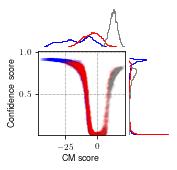

In [193]:
## On test set I 

# path to the score file
score_file = [prjdir + '/Softmax-conf/config_train_asvspoof2019/01/log_output_pretrained_config_test_asvspoof2019_score.txt']

merged_pd = load_pd(score_file, protocol_pd, None, None)

eer, _ = compute_eer(merged_pd)
fig, axis = plot_conf_cm_score(merged_pd)
fpr95, auroc, apc, eer95 = compute_metrics(merged_pd)
print_results(eer, eer95, fpr95, auroc, apc)

inoutlabel == 'in' and label == 'spoof' 19656
inoutlabel == 'out' and label == 'spoof' 93693
inoutlabel == 'in' and label == 'bonafide' 7355
inoutlabel == 'out' and label == 'bonafide' 770


/home/smg/wang/WORK/WORK/CODE/git_local/team/project-NN-Pytorch-scripts/tutorials/plot_tools/plot_API.py:325: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = fig.add_subplot(gs[grid_config[0][0]:grid_config[0][1],


Metrics without considering abstention: 
EER: 6.745%

Metrics for abstention: 
AUROC: 73.779%
AUPR: 51.788%

Metrics with abstention considered: 
EER at TPR=95%: 5.585%
FPR at TPR=95%: 77.894%


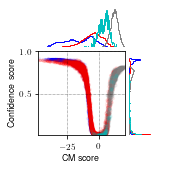

In [194]:
## On test set II 

# path to the score file
score_file = [prjdir + '/Softmax-conf/config_train_asvspoof2019/01/log_output_pretrained_config_test_asvspoof2019_score.txt',
              prjdir + '/Softmax-conf/config_train_asvspoof2019/01/log_output_pretrained_config_test_vcc_score.txt']

merged_pd = load_pd(score_file, protocol_pd, None, None)

eer, _ = compute_eer(merged_pd)
fig, axis = plot_conf_cm_score(merged_pd)
fpr95, auroc, apc, eer95 = compute_metrics(merged_pd)
print_results(eer, eer95, fpr95, auroc, apc)